Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Quantum Neural Networks

This notebook provides an introduction to Quantum Neural Networks (QNNs) using the Cirq. The presentation mostly follows [Farhi and Neven](https://arxiv.org/abs/1802.06002). We will construct a simple network for classification to demonstrate its utility on some randomly generated toy data.

First we need to install cirq, which has to be done each time this notebook is run. Executing the following cell will do that.

In [ ]:
# install published dev version
# !pip install cirq~=0.4.0.dev

# install directly from HEAD:
!pip install git+https://github.com/quantumlib/Cirq.git@8c59dd97f8880ac5a70c39affa64d5024a2364d0

  Cloning https://github.com/quantumlib/Cirq.git (to revision 8c59dd97f8880ac5a70c39affa64d5024a2364d0) to /tmp/pip-req-build-p85k13_x
    100% |████████████████████████████████| 12.6MB 837kB/s 
    100% |████████████████████████████████| 952kB 10.0MB/s 
  Running setup.py bdist_wheel for cirq ... - \ | / done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub0vqjao/wheels/ae/db/83/edbb28e59157c931c9342e7ae581bebdf4939c0465a413aaaf
Successfully built cirq
  Found existing installation: matplotlib 2.1.2
    Uninstalling matplotlib-2.1.2:
      Successfully uninstalled matplotlib-2.1.2


To verify that Cirq is installed in your environment, try to `import cirq` and print out a diagram of the Foxtail device. It should produce a 2x11 grid of qubits.

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

print(cirq.google.Foxtail)

(0, 0)───(0, 1)───(0, 2)───(0, 3)───(0, 4)───(0, 5)───(0, 6)───(0, 7)───(0, 8)───(0, 9)───(0, 10)
│        │        │        │        │        │        │        │        │        │        │
│        │        │        │        │        │        │        │        │        │        │
(1, 0)───(1, 1)───(1, 2)───(1, 3)───(1, 4)───(1, 5)───(1, 6)───(1, 7)───(1, 8)───(1, 9)───(1, 10)


### The QNN Idea
We'll begin by describing here the QNN model we are pursuing. We'll discuss the quantum circuit describing a very simple neuron, and how it can be trained.

As in an ordinary neural network, a QNN takes in data, processes that data, and then returns an answer. In the quantum case, the data will be encoded into the initial quantum state, and the processing step is the action of a quantum circuit on that quantum state. At the end we will measure one or more of the qubits, and the statistics of those measurements are the output of the net.



#### Classical vs Quantum

An ordinary neural network can only handle classical input. The input to a QNN, though, is a quantum state, which consists of $2^n$ complex amplitudes for $n$-qubits. If you attached your quantum computer directly to some physics experiment, for example, then you could have a QNN do some post-processing on the experimental wavefunction in lieu of a more traditional measurement. There are some very exciting possiblities there, but unfortunately we wil not be considering them in this Colab. It requires significantly more quantum background to understand what's going on, and it's harder to give examples because the input states themselves can be quite complicated. For recent examples of that kind of network, though, check out [this](https://arxiv.org/abs/1805.08654) paper and [this](https://arxiv.org/abs/1810.03787) paper. The basic ingredients are similar to what we'll cover here

In this Colab we'll focus on classical inputs, by which I mean the specification of one of the computational basis states as the initial state. There are a total of $2^n$ of these states for $n$ qubits. Note the crucial difference between this case and the quantum case: in the quantum case the input is $2^n$-*dimensional*, while in the classical case there are $2^n$ *possible* inputs. The quantum neural network can process these inputs in a "quantum" way, meaning that it may be able to evaluate certain functions on these inputs more efficiently than a classical network. Whether the "quantum" processing is actually useful in practice remains to be seen, and in this Colab we will not have time to really get into that aspect of a QNN.

#### Data Processing

Given the classical input state, what will we do with it? At this stage it's helpful to be more specific and definite about the problem we are trying to solve. The problem we're going to focus on in this Colab is __two-category classicfication__. That means that after the quantum circuit has finished running, we measure one of the qubits, the *readout* qubit, and the value of that qubit will tell us which of the two categories our classical input state belonged to. Since this is quantum, the output that qubit is going to be random according to some probability distributuion. So really we're going to repeat the computation many times and take a majority vote.

Our classical input data is a bitstring that is converted into a computational basis state. We want to influence the readout qubit in a way that depends on this state. Our main tool for this a gate we call the $ZX$-gate, which acts on two qubits as
$$
\exp(i \pi w Z \otimes X) = \begin{bmatrix}
\cos \pi w  & i\sin\pi w  &0&0\\
i\sin\pi w & \cos \pi w   &0&0\\
0&0& \cos \pi w  & -i\sin\pi w \\
0&0 & -i\sin\pi w  & \cos\pi w 
\end{bmatrix},
$$
where $w$ is a free parameter ($w$ stands for weight). This gate rotates the second qubit around the $X$-axis (on the Bloch sphere) either clockwise or counterclockwise depending on the state of the first qubit as seen in the computational basis. The amount of the rotation is determined by $w$.

If we connect each of our input qubits to the readout qubit using one of these gates, then the result is that the readout qubit will be rotated in a way that depeonds the initial state in a straightforward way. This rotation is in the $YZ$ plane, so will change the statistics of measurements in either the $Z$ basis or the $Y$ basis for the readout qubit. We're going to choose to have the initial state of the readout qubit to be a standard computational basis state as usual, which is a $Z$ eigenstate but "neutral" with respect to $Y$ (i.e., 50/50 probabilty of $Y=+1$ or $Y=-1$). Then after all of the rotations are complete we'll measure the readout qubit in the $Y$ basis. If all goes well, then the net rotation induced by the $ZX$ gates will place the readout qubit near one of the two $Y$ eigenstates in a way that depends on the initial data.

To summarize, here is our strategy for processing the two-category classification problem:

1) Prepare a computational basis state corresponding to the input that should be categorized.

2) Use $ZX$ gates to rotate the state of the readout qubit in a way that depends on the input.

3) Measure the readout qubit in the $Y$ basis to get the predicted label. Take a majority vote after many repetitions.

This is the simplest possible kind of network, and really only corresponds to a single neuron. We'll talk about more complicated possibilities after understanding how to implement this one.

### Custom Two-Qubit Gate

Our first task is to code up the $ZX$ gate described above, which is given by the matrix
$$
\exp(i \pi w Z \otimes X) = \begin{bmatrix}
\cos \pi w  & i\sin\pi w  &0&0\\
i\sin\pi w & \cos \pi w   &0&0\\
0&0& \cos \pi w  & -i\sin\pi w \\
0&0 & -i\sin\pi w  & \cos\pi w 
\end{bmatrix},
$$

Just from the form of the gate we can see that it performs a rotation by angle $\pm \pi w$ on the second qubit depending on the value of the first qubit. If we only had one or the other of these two blocks, then this gate would literally be a controlled rotation. For example, using the Cirq conventions,
$$
CR_X(\theta) = \begin{bmatrix}
1  & 0  &0&0\\
0 & 1   &0&0\\
0&0& \cos \theta/2  & -i\sin \theta/2 \\
0&0 & -i\sin\theta/2  & \cos\theta/2 
\end{bmatrix},
$$
which means that setting $\theta = 2\pi w$ should give us (part) of our desired transformation.

In [ ]:
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
w = .25 # Put your own weight here.
angle = 2*np.pi*w
circuit = cirq.Circuit.from_ops(cirq.ControlledGate(cirq.Rx(angle)).on(a,b))
print(circuit)
circuit.to_unitary_matrix().round(2)

a: ───@──────────
      │
b: ───Rx(0.5π)───


array([[1.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 1.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 0.71+0.j  , 0.  -0.71j],
       [0.  +0.j  , 0.  +0.j  , 0.  -0.71j, 0.71+0.j  ]])

__Question__: The rotation in the upper-left block is by the opposite angle. But how do we get the rotation to happen in the upper-left block of the $4\times 4$ matrix in the first place? What is the circuit?

#### Solution

Switching the upper-left and lower-right blocks of a controlled gate corresponds to activating when the control qubit is in the $|0\rangle$ state instead of the $|1\rangle$ state. We can arrange this to happen by taking the control gate we already have and conjugating the control qubit by $X$ gates (which implement the NOT operation). Don't forget to also rotate by the opposite angle.

In [ ]:
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
w = 0.25 # Put your own weight here.
angle = 2*np.pi*w
circuit = cirq.Circuit.from_ops([cirq.X(a),
                                 cirq.ControlledGate(cirq.Rx(-angle)).on(a,b),
                                 cirq.X(a)])
print(circuit)
circuit.to_unitary_matrix().round(2)

a: ───X───@───────────X───
          │
b: ───────Rx(-0.5π)───────


array([[0.71+0.j  , 0.  +0.71j, 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.71j, 0.71+0.j  , 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 1.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 1.  +0.j  ]])

#### The Full $ZX$ Gate

We can put together the two controlled rotations to make the full $ZX$ gate. Having discussed the decomposition already, we can make our own class and specify its action using the `_decpompose_` method. Fill in the following code block to implement this gate.

In [ ]:
class ZXGate(cirq.ops.gate_features.TwoQubitGate):
  """ZXGate with variable weight."""
  
  def __init__(self, weight=1):
    """Initializes the ZX Gate up to phase.

     Args:
         weight: rotation angle, period 2 
    """
    self.weight = weight
  
  def _decompose_(self, qubits):
    a, b = qubits
    ## YOUR CODE HERE

  # This lets the weight be a Symbol. Useful for paramterization.
  def _resolve_parameters_(self, param_resolver):
    return ZXGate(weight=param_resolver.value_of(self.weight))

  # How should the gate look in ASCII diagrams?
  def _circuit_diagram_info_(self, args):        
    return cirq.protocols.CircuitDiagramInfo(
           wire_symbols=('Z', 'X'),
           exponent=self.weight) 

#### Solution

In [ ]:
class ZXGate(cirq.ops.gate_features.TwoQubitGate):
  """ZXGate with variable weight."""
  
  def __init__(self, weight=1):
    """Initializes the ZX Gate up to phase.

     Args:
         weight: rotation angle, period 2 
    """
    self.weight = weight
  
  def _decompose_(self, qubits):
    a, b = qubits
    yield cirq.ControlledGate(cirq.Rx(2*np.pi*self.weight)).on(a,b)
    yield cirq.X(a)
    yield cirq.ControlledGate(cirq.Rx(-2*np.pi*self.weight)).on(a,b)
    yield cirq.X(a)

  # This lets the weight be a Symbol. Useful for paramterization.
  def _resolve_parameters_(self, param_resolver):
    return ZXGate(weight=param_resolver.value_of(self.weight))

  # How should the gate look in ASCII diagrams?
  def _circuit_diagram_info_(self, args):        
    return cirq.protocols.CircuitDiagramInfo(
           wire_symbols=('Z', 'X'),
           exponent=self.weight) 

#### EigenGate Implementation

Another way to specify how a gate works is by an explicit eigen-action. In our case that is also easy, since we know that the gate acts as a phase (the eigenvalue) when the first qubit is in a $Z$ eigenstate (i.e., a computational basis state) and the second qubit is in an $X$ eigenstate.

The way we specify eigen-actions in Cirq is through the `_eigen_components` method, where we need to specify the eigenvalue as a phase together with a projector onto the eigenspace of that phase. We also conventionally specify the gate at $w=1$ and set $w$ internally to be the `exponent` of the gate, which automatically implements other values of $w$ for us.

In the case of the $ZX$ gate with $w=1$, one of our eigenvalues is $\exp(+i\pi)$, which is specified as $1$ in Cirq. (Because $1$ is the coefficeint of $i\pi$ in the exponential.) This is the phase when when the first qubit is in the $Z=+1$ state and the second qubit is in the $X=+1$ state, or when the first qubit is in the $Z=-1$ state and the second qubit is in the $X=-1$ state. The projector onto these states is
$$
\begin{align}
P &= |0+\rangle \langle 0{+}| +  |1-\rangle \langle 1{-}|\\
&= \frac{1}{2}\big(|00\rangle \langle 00| +|00\rangle \langle 01|+|01\rangle \langle 00|+|01\rangle \langle 01|+  |10\rangle \langle 10|-|10\rangle \langle 11|-|11\rangle \langle 10|+|11\rangle \langle 11|\big)\\
&=\frac{1}{2}\begin{bmatrix}
1  & 1  &0&0\\
1 & 1   &0&0\\
0&0& 1  & -1 \\
0&0 & -1   & 1
\end{bmatrix}
\end{align}
$$
A similar formula holds for the eigenvalue $\exp(-i\pi)$ with the two blocks in the projector flipped.


__Exercise__: Implement the $ZX$ gate as an `EigenGate` using this decomposition. The following codeblock will get you started.


In [ ]:
class ZXGate(cirq.ops.eigen_gate.EigenGate,
             cirq.ops.gate_features.TwoQubitGate):
  """ZXGate with variable weight."""
  
  def __init__(self, weight=1):
    """Initializes the ZX Gate up to phase.

     Args:
         weight: rotation angle, period 2 
    """
    self.weight = weight
    super().__init__(exponent=weight) # Automatically handles weights other than 1
  
  def _eigen_components(self):
    return [
        (1, np.array([[0.5, 0.5, 0, 0],
                      [ 0.5, 0.5, 0, 0],
                      [0, 0, 0.5, -0.5],
                      [0, 0, -0.5, 0.5]])),
        (??, ??) # YOUR CODE HERE: phase and projector for the other eigenvalue
    ]

  # This lets the weight be a Symbol. Useful for parameterization.
  def _resolve_parameters_(self, param_resolver):
    return ZXGate(weight=param_resolver.value_of(self.weight))

  # How should the gate look in ASCII diagrams?
  def _circuit_diagram_info_(self, args):        
    return cirq.protocols.CircuitDiagramInfo(
           wire_symbols=('Z', 'X'),
           exponent=self.weight) 

#### Solution

In [ ]:
class ZXGate(cirq.ops.eigen_gate.EigenGate,
             cirq.ops.gate_features.TwoQubitGate):
  """ZXGate with variable weight."""
  
  def __init__(self, weight=1):
    """Initializes the ZX Gate up to phase.

     Args:
         weight: rotation angle, period 2 
    """
    self.weight = weight
    super().__init__(exponent=weight) # Automatically handles weights other than 1
  
  def _eigen_components(self):
    return [
        (1, np.array([[0.5, 0.5, 0, 0],
                      [ 0.5, 0.5, 0, 0],
                      [0, 0, 0.5, -0.5],
                      [0, 0, -0.5, 0.5]])),
        (-1, np.array([[0.5, -0.5, 0, 0],
                      [ -0.5, 0.5, 0, 0],
                      [0, 0, 0.5, 0.5],
                      [0, 0, 0.5, 0.5]]))
    ]

  # This lets the weight be a Symbol. Useful for parameterization.
  def _resolve_parameters_(self, param_resolver):
    return ZXGate(weight=param_resolver.value_of(self.weight))

  # How should the gate look in ASCII diagrams?
  def _circuit_diagram_info_(self, args):        
    return cirq.protocols.CircuitDiagramInfo(
           wire_symbols=('Z', 'X'),
           exponent=self.weight) 

#### Testing the Gate

__BEFORE MOVING ON__ make sure you've executed the `EigenGate` solution of the $ZX$ gate implementation. That's the one assumed for the code below, though other implementations may work just as well. In general, the cells in this Colab may depend on previous cells.

Let's test out our gate. First we'll make a simple test circuit to see that the ASCII diagrams are diplaying properly:

In [ ]:
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
w = .15 # Put your own weight here. Try using a cirq.Symbol.
circuit = cirq.Circuit.from_ops(ZXGate(w).on(a,b))
print(circuit)

a: ───Z────────
      │
b: ───X^0.15───


We should also check that the matrix is what we expect:

In [ ]:
test_matrix = np.array([[np.cos(np.pi*w), 1j*np.sin(np.pi*w), 0, 0],
                        [1j*np.sin(np.pi*w), np.cos(np.pi*w), 0, 0],
                        [0, 0, np.cos(np.pi*w), -1j*np.sin(np.pi*w)],
                        [0, 0, -1j*np.sin(np.pi*w),np.cos(np.pi*w)]])
# Test for five digits of accuracy. Won't work with cirq.Symbol
assert (circuit.to_unitary_matrix().round(5) == test_matrix.round(5)).all()

### Create Circuit

Now we have to create the QNN circuit. We are simply going to let a $ZX$ gate act between each data qubit and the readout qubit. For simplicity, let's share a single weight between all of the gates. You are invited to experiment with making the weights different, but in our example problem below we can set them all equal by symmetry.

__Question__: What about the order of these actions? Which data qubits should interact with the readout qubit first?

Remember that we also want to measure the readout qubit in the $Y$ basis. Fundamentally speaking, all measurements in Cirq are computational basis measurements, and so we have to implement the change of basis by hand.


__Question__: What is the circuit for a basis transformation from the $Y$ basis to the computational basis? We want to choose our transformation so that an eigenstate with $Y=+1$ becomes an eigenstate with $Z=+1$ prior to measurement.

#### Solutions

* The $ZX$ gates all commute with each other, so the order of implementation doesn't matter!

* We want a transformation that maps $\big(|0\rangle + i |1\rangle\big)/\sqrt{2}$ to $|0\rangle$ and $\big(|0\rangle - i |1\rangle\big)\sqrt{2}$ to $|1\rangle$. Recall that the phase gate $S$ is given in matrix form by
$$
S = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix},
$$
and the Hadamard transform is given by
$$
H = \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix},
$$
So acting with $S^{-1}$ and then $H$ gives what we want. We'll add these two gates to the end of the circuit on the readout qubit so that the final measurement effectively occurs in the $Y$ basis.



#### Make Circuit

A clean way of making circuits is to define generators for logically-related circuit elements, and then `append` those to the circuit you want to make. Here is a code snippet that initializes our qubits and defines a generator for a single layer of $ZX$ gates:

In [ ]:
# Total number of data qubits
INPUT_SIZE = 9

data_qubits = cirq.LineQubit.range(INPUT_SIZE)
readout = cirq.NamedQubit('r')

# Initialize parameters of the circuit
params = {'w': 0}

def ZX_layer():
  """Adds a ZX gate between each data qubit and the readout.
  All gates are given the same cirq.Symbol for a weight."""
  for qubit in data_qubits:
    yield ZXGate(cirq.Symbol('w')).on(qubit, readout)

Use this generator to create the QNN circuit. Don't forget to add the basis change for the readout qubit at the end!

In [ ]:
qnn = cirq.Circuit()
qnn.append(???) # YOUR CODE HERE

#### Solution 

In [ ]:
qnn = cirq.Circuit()
qnn.append(ZX_layer())
qnn.append([cirq.S(readout)**-1, cirq.H(readout)]) # Basis transformation

#### View the Circuit

It's usually a good idea to view the ASCII diagram of your circuit to make sure it's doing what you want. This can be displayed by printing the circuit.

In [ ]:
print(qnn)

0: ───Z────────────────────────────────────────────────────────────────
      │
1: ───┼─────Z──────────────────────────────────────────────────────────
      │     │
2: ───┼─────┼─────Z────────────────────────────────────────────────────
      │     │     │
3: ───┼─────┼─────┼─────Z──────────────────────────────────────────────
      │     │     │     │
4: ───┼─────┼─────┼─────┼─────Z────────────────────────────────────────
      │     │     │     │     │
5: ───┼─────┼─────┼─────┼─────┼─────Z──────────────────────────────────
      │     │     │     │     │     │
6: ───┼─────┼─────┼─────┼─────┼─────┼─────Z────────────────────────────
      │     │     │     │     │     │     │
7: ───┼─────┼─────┼─────┼─────┼─────┼─────┼─────Z──────────────────────
      │     │     │     │     │     │     │     │
8: ───┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────Z────────────────
      │     │     │     │     │     │     │     │     │
r: ───X^w───X^w───X^w───X^w───X^w───X^w───X^w───X^w───X^w───S^-1

You can experiment with adding more layers of $ZX$ gates (or adding other kinds of transformations!) to your QNN, but we can use this simplest kind of circuit to analyze a simple toy problem, which is what we will do next.

### A Toy Problem: Biased Coin Flips

As a toy problem, let's get our quantum neuron to decide whether a coin is biased toward heads or toward tails based on a sequence of coin flips.

To be specific, let's try to train a QNN to distinguish between a coin that yields "heads" with probability $p$, and one that yields "heads" with probability $1-p$. Without loss of generality, let's say that $p\leq 0.5$. We don't need a fancy QNN to come up with a winning strategy: given a series of coin flips, you guess $p$ if the majority of flips are "tails" and $1-p$ if the majority are "heads." But for purposes of illustration, let's do it the fancy way.

To translate this problem into our QNN language, we need to encode the sequence of coin flips into a computational basis state. Let's associate $0$ with tails and $1$ with heads. So the sequence of coin flips becomes a sequence of $0$s and $1$s, and these define a computational basis state.

We also need to define a convention for our labeling of the two coins. We'll say that the $p$ coin (majority tails) gets the label $-1$ and the $1-p$ coin (majority heads) gets the label $+1$. So when we measure $Y$ at the end of the computation we can say that the majority-vote of the $Y$ outcome is our predicted label.

To be a little more nuanced (and to aid the formulation of the problem), let's say that the expectation value  $\langle Y \rangle$  for a given input state defines our estimator for the label of that state. We're going to use that to define a loss function for training next.


### Define Loss Function

Suppose we have a collection of $N$ (bitstring, label) pairs. A useful loss function to characterize the effectiveness of our QNN on this collection is
$$
\text{Loss} = \frac{1}{2N}\sum_{j=1}^n (1- \ell_j\langle Y \rangle_j),
$$
where $\ell_j$ is the label of the $j$th pair and $\langle Y \rangle_j$ is the expectation value of $Y$ on the readout qubit using the $j$th bitstring as input. If the network is perfect, the loss is equal to zero. If the network is maximally unsure about the labels (so that $\langle Y \rangle_j = 0$ for all $j$) then the loss is equal to $1/2$. And if the network gets everything wrong, then the loss is equal to $1$. We're going to train our network using this loss function, so next we'll write some functions to compute the loss.

Another useful function to have around is the average classification error. Recall that our prescription was to execute the quantum circuit many times and take a majority vote to compute the predicted label. The majority vote for the readout is the same as $\text{sign}(\langle Y \rangle)$, so we can write a formula for the error in this procedure as
$$
\text{Error} = \frac{1}{2N}\sum_{j=1}^n \big(1- \ell_j\text{sign}\big(\langle Y \rangle_j\big)\big).
$$
This is not so useful as a loss function because it is not smooth and does not provide an incentive to make $|\langle Y \rangle|$ large, but it can be an informative quantity to compute.

__Question__: Why would we want $|\langle Y \rangle|$ to be large?

#### Solution

When we implement this algorithm on the actual hardware, $\langle Y \rangle$ can only be estimated by repeatedly executing the circuit and measuring the result. The more measurements we make, the better our estimate of $\langle Y \rangle$ will be. Even if we are only interested in $\text{sign}\big(\langle Y \rangle\big)$, we will need to meake enough measurements to be sure that our estimate has the correct sign, and if $|\langle Y \rangle|$ is large then fewer measurements will be required to have high confidence in the sign.


Furthermore, if the machine is noisy (which it will be), then the noise will induce some errors in our estimate of $\langle Y \rangle$. If $|\langle Y \rangle|$ is small then it's likely that the noise will lead to the wrong sign.

#### Expectation Value

Our first function computes the expectation value of the readout qubit for our circuit given a specification of the initial state. Rather than a bitstring, we'll specify the initial state as an array of $0$s and $1$s. These are the outputs of the coin flips in our toy problem. We'll compute the expectation value exactly using the wavefunction for now.

In [ ]:
def readout_expectation(state):
  """Takes in a specification of a state as an array of 0s and 1s
  and returns the expectation value of Z on ther readout qubit.
  Uses the XmonSimulator to calculate the wavefunction exactly."""  
  
  # A convenient representation of the state as an integer
  state_num = int(np.sum(state*2**np.arange(len(state))))

  resolver = cirq.ParamResolver(params)
  simulator = cirq.Simulator()

  # Specify an explicit qubit order so that we know which qubit is the readout
  result = simulator.simulate(qnn, resolver, qubit_order=[readout]+data_qubits,
                              initial_state=state_num)
  wf = result.final_state

  # Becase we specified qubit order, the Z value of the readout is the most
  # significant bit.
  Z_readout = np.append(np.ones(2**INPUT_SIZE), -np.ones(2**INPUT_SIZE))

  return np.sum(np.abs(wf)**2 * Z_readout)

#### Loss and Error

The next functions take a list of states (each specified as an array of $0$s and $1$s as before) and a corresponding list of labels and computes the loss and error, respectively, of that list.

In [ ]:
def loss(states, labels):
  loss=0
  for state, label in zip(states,labels):
    loss += 1 - label*readout_expectation(state)
  return loss/(2*len(states))
  
def classification_error(states, labels):
  error=0
  for state,label in zip(states,labels):
    error += 1 - label*np.sign(readout_expectation(state))
  return error/(2*len(states))

#### Generating Data

For our toy problem we'll want to be able to generate a batch of data. Here is a helper function for that task:

In [ ]:
def make_batch():
  """Generates a set of labels, then uses those labels to generate inputs.
  label = -1 corresponds to majority 0 in the sate, label = +1 corresponds to
  majority 1.
  """
  np.random.seed(0) # For consistency in demo
  labels = (-1)**np.random.choice(2, size=100) # Smaller batch sizes will speed up computation
  states = []
  for label in labels:
    states.append(np.random.choice(2, size=INPUT_SIZE, p=[0.5-label*0.2,0.5+label*0.2]))
  return states, labels

states, labels = make_batch()

### Training

Now we'll try to find the optimal weight to solve our toy problem. For illustration, we'll do both a brute force search of the paramter space as well as a stochastic gradient descent.

#### Brute Force Search

Let's compute both the loss and error rate on a batch of data as a function of the shared weight between all the gates.

In [ ]:
# Using cirq.Simulator with the EigenGate implementation of ZZ, this takes
# about 30s to run. Using the XmonSimulator took about 40 minutes the last
# time I tried it!
%%time
linspace = np.linspace(start=-1, stop=1, num=80)
train_losses = []
error_rates = []
for p in linspace:
  params = {'w': p}
  train_losses.append(loss(states, labels))
  error_rates.append(classification_error(states, labels))

CPU times: user 29.5 s, sys: 2.93 ms, total: 29.5 s
Wall time: 29.6 s


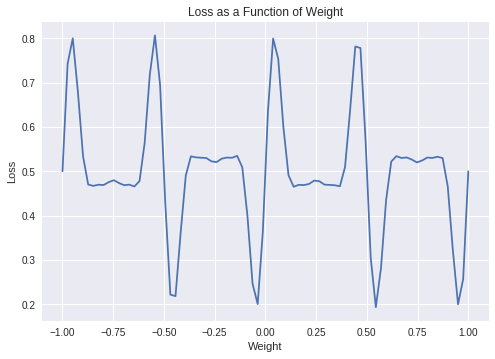

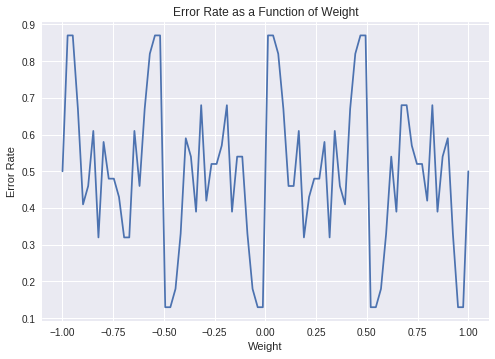

In [ ]:
plt.plot(linspace, train_losses)
plt.xlabel('Weight')
plt.ylabel('Loss')
plt.title('Loss as a Function of Weight')
plt.show()
plt.plot(linspace, error_rates)
plt.xlabel('Weight')
plt.ylabel('Error Rate')
plt.title('Error Rate as a Function of Weight')
plt.show()

__Question__: Why are the loss and error functions periodic with period $1$ when the $ZX$ gate is periodic with period $2$?

#### Solution

This kind of "halving" of the periodicity of $\langle Y \rangle$ compared to the period of the gates itself is typical of qubit systems. We can analyze how it works mathematically in a simpler setting. Instead of the $ZX$ Gate, let's just imagine that we rotate the readout qubit around the $X$ axis by some fixed amout. This is the effective calculation for a single fixed data input.
$$
\begin{align}
\langle Y \rangle &= \langle 0 |\exp(-i \pi w X) Y  \exp(i \pi w X) |0 \rangle\\
&= \langle 0 |\big(\cos \pi w - i X\sin \pi w \big) Y \big(\cos \pi w + i X \sin \pi w \big) |0 \rangle\\
&= \langle 0 |\big(Y\cos 2\pi w  +Z \sin 2\pi w \big) |0 \rangle\\
&= \sin 2\pi w.
\end{align}
$$

#### Stochastic Gradient Descent

To train the network we'll use stochastic gradient descent. Note that this isn't necessarily a good idea since the loss function is far from convex, and there's a good chance we'll get stuck in very inefficient local minimum if we initialize the paramters randomly. But as an exercise we'll do it anyway. In the next section we'll discuss other ways to train these sorts of networks.

We'll compute the gradient of the loss function using a symmetric finite-difference approximation: $f'(x) \approx (f(x + \epsilon) - f(x-\epsilon))/2\epsilon$. This is the most straightforward way to do it using the quantum computer. We'll also generate a new instance of the problem each time.

In [ ]:
def stochastic_grad_loss():
  """Generates a new data point and computes the gradient of the loss
  using that data point."""
  
  # Randomly generate the data point.
  label = (-1)**np.random.choice(2)
  state = np.random.choice(2, size=INPUT_SIZE, p=[0.5-label*0.2,0.5+label*0.2])
  
  # Compute the gradient using finite difference
  eps = 10**-5 # Discretization of gradient. Try different values.
  params['w'] -= eps
  loss1 = loss([state],[label])
  params['w'] += 2*eps
  grad = (loss([state],[label])-loss1)/(2*eps)
  params['w'] -= eps # Reset the parameter value
  return grad

We can apply this function repeatedly to flow toward the minimum:

In [ ]:
eta = 10**-4 # Learning rate. Try different values.
params = {'w': 0} # Initialize weight. Try different values.
for i in range(201):
  if not i%25:
    print('Step: {} Loss: {}'.format(i, loss(states, labels)))
  grad = stochastic_grad_loss()
  params['w'] += -eta*grad
print('Final Weight: {}'.format(params['w']))

Step: 0 Loss: 0.5
Step: 25 Loss: 0.29664170142263174
Step: 50 Loss: 0.21596111725317313
Step: 75 Loss: 0.19353972657117993
Step: 100 Loss: 0.1930989919230342
Step: 125 Loss: 0.19318223176524044
Step: 150 Loss: 0.19358215024578385
Step: 175 Loss: 0.1965144828868506
Step: 200 Loss: 0.1930640292633325
Final Weight: -0.0443500901565141


### Use Sampling Instead of Calculating from the Wavefunction

On real hardware we will have to use sampling to find results instead of computing the exact wavefunction. Rewrite the `readout_expectation` function to compute the expectation value using sampling instead. Unlike with the wavefunction calculation, we also need to build our circuit in a way that accounts for the initial state (we are always assumed to start in the all $|0\rangle$ state)




In [ ]:
def readout_expectation_sample(state):
  """Takes in a specification of a state as an array of 0s and 1s
  and returns the expectation value of Z on ther readout qubit.
  Uses the XmonSimulator to sample the final wavefunction."""
  
  # We still need to resolve the parameters in the circuit.
  resolver = cirq.ParamResolver(params)
  
  # Make a copy of the QNN to avoid making changes to the global variable.
  measurement_circuit = qnn.copy()
  
  # Modify the measurement circuit to account for the desired input state.  
  # YOUR CODE HERE
  
  # Add appropriate measurement gate(s) to the circuit.
  # YOUR CODE HERE
  
  simulator = cirq.google.XmonSimulator()   
  result = simulator.run(measurement_circuit, resolver, repetitions=10**6) # Try adjusting the repetitions
  
  # Return the Z expectation value
  return ((-1)**result.measurements['m']).mean()

#### Solution

In [ ]:
def readout_expectation_sample(state):
  """Takes in a specification of a state as an array of 0s and 1s
  and returns the expectation value of Z on ther readout qubit.
  Uses the XmonSimulator to sample the final wavefunction."""
  
  # We still need to resolve the parameters in the circuit.
  resolver = cirq.ParamResolver(params)
  
  # Make a copy of the QNN to avoid making changes to the global variable.
  measurement_circuit = qnn.copy()
  
  # Modify the measurement circuit to account for the desired input state.  
  for i, qubit in enumerate(data_qubits):
    if state[i]:
      measurement_circuit.insert(0,cirq.X(qubit))
  
  # Add appropriate measurement gate(s) to the circuit.
  measurement_circuit.append(cirq.measure(readout, key='m'))
  
  simulator = cirq.Simulator()   
  result = simulator.run(measurement_circuit, resolver, repetitions=10**6) # Try adjusting the repetitions
  
  # Return the Z expectation value
  return ((-1)**result.measurements['m']).mean()

#### Comparison of Sampling with the Exact Wavefunction

Just to illustrate the difference between sampling and using the wavefunction, try running the two methods several times on identical input:


In [ ]:
state = [0,0,0,1,0,1,1,0,1] # Try different initial states.
params = {'w': 0.05} # Try different weights.

print("Exact expectation value: {}".format(readout_expectation(state)))
print("Estimates from sampling:")
for _ in range(5):
  print(readout_expectation_sample(state))

Exact expectation value: 0.3090169429779053
Estimates from sampling:
0.308354
0.306674
0.309026
0.310854
0.30854


As an exercise, try repeating some of the above calculations (e.g., the SGD optimization) using `readout_expectation_sample` in place of `readout_expectation`. How many repetitions should you use? How should the hyperparameters `eps` and `eta` be adjusted in response to the number of repetitions?

### Optimizing For Hardware

There are more issues to think about if you want to run your network on real hardware. First is the connectivity issue, and second is minimizing the number of two-qubit operations.

Consider the Foxtail device:

In [ ]:
print(cirq.google.Foxtail)

(0, 0)───(0, 1)───(0, 2)───(0, 3)───(0, 4)───(0, 5)───(0, 6)───(0, 7)───(0, 8)───(0, 9)───(0, 10)
│        │        │        │        │        │        │        │        │        │        │
│        │        │        │        │        │        │        │        │        │        │
(1, 0)───(1, 1)───(1, 2)───(1, 3)───(1, 4)───(1, 5)───(1, 6)───(1, 7)───(1, 8)───(1, 9)───(1, 10)


The qubits are arranged in two rows of eleven qubits each, and qubits can only communicate to their nearest neighbors along the horizontal and vertial connections. That does not mesh well with the QNN we designed, where all of the data qubits need to interact with the readout qubit.

There is no *in-principle* restriction on the kinds of algorithms you are allowed to run. The solution to the connectivity problem is to make use of SWAP gates, which have the effect of exchanging the states of two (neighboring) qubits. It's equivalent to what you would get if you physically exchanged the positions of two of the qubits in the grid. The problem is that each SWAP operation is costly, so you want to avoid SWAPing as much as possible. We need to think carefully about our algorithm design to minimize the number of SWAPs performed as the circuit is executed.

__Question__: How should we modify our QNN circuit so that it can runs efficiently on the Foxtail device?

#### Solution

One strategy is to move the readout qubit around as it talks to the other qubits. Suppose the readout qubit starts in the $(0,0)$ position. First it can interact with the qubits in the $(1,0)$ and $(0,1)$ positons like normal, then SWAP with the $(0,1)$ qubit. Now the readout qubit is in the $(0,1)$ position and can interact with the $(1,1)$ and $(0,2)$ qubits before SWAPing with the $(0,2)$ qubit. It continues down the line in this fashion.

Let's code up this circuit:

In [ ]:
qnn_fox = cirq.Circuit()

w = 0.2 # Want an explicit numerical weight for later 
for i in range(10):
  qnn_fox.append([ZXGate(w).on(cirq.GridQubit(1,i), cirq.GridQubit(0,i)),
                  ZXGate(w).on(cirq.GridQubit(0,i+1), cirq.GridQubit(0,i)),
                  cirq.SWAP(cirq.GridQubit(0,i), cirq.GridQubit(0,i+1))])
  
qnn_fox.append(ZXGate(w).on(cirq.GridQubit(1,10), cirq.GridQubit(0,10)))

qnn_fox.append([(cirq.S**-1)(cirq.GridQubit(0,10)),cirq.H(cirq.GridQubit(0,10)),
               cirq.measure(cirq.GridQubit(0,10))])

print(qnn_fox)

(0, 0): ────X───────X───────×──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            │       │       │
(0, 1): ────┼───────Z^0.2───×───X───────X───────×──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            │                   │       │       │
(0, 2): ────┼───────────────────┼───────Z^0.2───×───X───────X───────×──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            │                   │                   │       │       │
(0, 3): ────┼───────────────────┼───────────────────┼───────Z^0.2───×───X───────X───────×─────────────────────────────────────────────────────

As coded, this circuit still won't run on the Foxtail device. That's because the gates we've defined are not native gates. Cirq has a built-in method that will convert our gates to Xmon gates (which are native for the Foxtail device) and attempt to optimze the circuit by reducing the total number of gates:

In [ ]:
cirq.google.optimized_for_xmon(qnn_fox, new_device=cirq.google.Foxtail, allow_partial_czs=True)

(0, 0): ────Y^-0.5───@───────PhasedX(0.4)^0.5───@───PhasedX(0.4)^0.5───@───PhasedX(-0.6)^0.5────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │                          │                      │                            │
(0, 1): ────X^0.5────┼──────────────────────────@───X^-0.5─────────────@───PhasedX(-2.22e-16)^0.5───@^0.2───@────────PhasedX(-0.8)^0.5───@───PhasedX(-0.8)^0.5───@───PhasedX(0.2)^0.5───@────────PhasedX(0.8)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │                                                                                      │                            │                       │                      │
(0, 2): ────X^0.5────┼──────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────@───X^0.5───────────────@───X^0.5──────────────@^-0.2───@──────────────PhasedX(1.0)^0.5───@───PhasedX(1.0)^0.5───@───PhasedX(-4.44e-16)^0.5───@────────PhasedX(0.7)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │                                                                                      │                                                                                    │                                 │                      │                            │
(0, 3): ────X^0.5────┼──────────────────────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────@───X^0.5──────────────@───X^0.5────────────────────@^-0.2───@──────────────PhasedX(1.0)^0.5───@───PhasedX(1.0)^0.5───@───PhasedX(-4.44e-16)^0.5───@────────PhasedX(0.7)─────────────────────────────────────────────────────────

Notice how we were able to pass in the `new_device` argument without getting an error messgae. That means the circuit will run properly on the Foxtail.


__Question__: We were smart to place the SWAP gates and $ZX$ gates next to each other where possible. Why?

__Question__: Can you see any ways to further optimize this circuit by hand? Hint: not all of the qubits are being measured.

#### Solutions

* Placing the SWAP and $ZX$ gates next to each other lets the optimizer treat the ocmbination of them as a single gate, which leads to fewer total two-qubit gates. 

* The state of any qubit which is not being measured does not matter. In particular, any single-qubit gate acting on a non-measured qubit after the last two-qubit gate acting on that qubit will not affect the state of the measured qubit and so can be dropped.

### Exercise: Multiple Weights

Instead of just a single weight, create create a neuron with multiple weights. How will you optimize those weights?

### Exercise: Analytic Calculation

Because we stuck to such a simple example, essentially everything in this notebook can be calculated analytically. Do those calculations.

### Exercise: Add More "Quantum" Operations

The neuron we constructed essentially does a classial calculation. You can add more ingredients that make the data processing more "quantum." For example, you can add layers of Hadamard gates in between additional layers of $ZX$ gates. This sort of thing was explored in [Farhi and Neven](https://arxiv.org/abs/1802.06002). Try playing around with it.